In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dgl
!pip install category_encoders
!pip install dgl-cu116 dglgo -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 37.4 MB/s 
     |████████████████████████████████| 280 kB 69.5 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 895 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 246.3 MB 36 kB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
     |████████████████████████████████| 78 kB 9.7 MB/s 
     |████████████████████████████████| 103 kB 78.8 MB/s 
     |████████████████████████████████| 29.1 MB 1.3 MB/s 
     |████████████████████████████████| 109 kB 73.4 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 45 kB 4.4 MB/s 
     |████████████████████████████████| 41 kB 265 kB/s 
     |████████████████████████████████| 3.2 MB 59.1 MB/s 
     |████████████████████████████████| 500 kB 70.7 MB/s 
     |████████████████████████████████| 1.1 MB 64.8 MB/s 
     

In [ ]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NF-UNSW-NB15/NF-UNSW-NB15.csv')

In [ ]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,149.171.126.0,62073,59.166.0.5,56082,6,0.0,9672,416,11,8,25,15,0,Benign
1,149.171.126.2,32284,59.166.0.5,1526,6,0.0,1776,104,6,2,25,0,0,Benign
2,149.171.126.0,21,59.166.0.1,21971,6,1.0,1842,1236,26,22,25,1111,0,Benign
3,59.166.0.1,23800,149.171.126.0,46893,6,0.0,528,8824,10,12,27,124,0,Benign
4,59.166.0.5,63062,149.171.126.2,21,6,1.0,1786,2340,32,34,25,1459,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623113,59.166.0.2,1640,149.171.126.8,53,17,0.0,130,162,2,2,0,0,0,Benign
1623114,59.166.0.2,3610,149.171.126.6,21,6,1.0,2044,2404,36,34,26,0,0,Benign
1623115,59.166.0.2,4667,149.171.126.6,40725,6,0.0,320,1918,6,8,27,0,0,Benign
1623116,59.166.0.2,5641,149.171.126.6,56243,6,0.0,528,8824,10,12,27,0,0,Benign


In [ ]:
data.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS',
       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack'],
      dtype='object')

In [ ]:
data.Attack.value_counts()

Benign            1550712
Exploits            24736
Fuzzers             19463
Reconnaissance      12291
Generic              5570
DoS                  5051
Analysis             1995
Backdoor             1782
Shellcode            1365
Worms                 153
Name: Attack, dtype: int64

In [ ]:
def change_label(data):
  data.Attack.replace(['DoS'],'Dos',inplace=True)
  data.Attack.replace(['Reconnaissance'],'Probe',inplace=True)
  data.Attack.replace(['Generic','Analysis','Exploits','Shellcode','Fuzzers'],'U2R',inplace=True)
  data.Attack.replace(['Benign'],'Normal',inplace=True)
  data.Attack.replace(['Backdoor','Worms'],'R2L',inplace=True)
change_label(data)
data.Attack.value_counts()

Normal    1550712
U2R         53129
Probe       12291
Dos          5051
R2L          1935
Name: Attack, dtype: int64

In [ ]:
data.drop(data.loc[data['Attack']=='Normal'].index[:1000000], axis=0, inplace=True)
# data.drop(data.loc[data['Attack']=='Dos'].index[:520000], axis=0, inplace=True)
# data.drop(data.loc[data['Attack']=='Probe'].index[:100000], axis=0, inplace=True)
# data.drop(data.loc[data['Attack']=='R2L'].index[:30000], axis=0, inplace=True)

In [ ]:
# distribution of attack classes
data.Attack.value_counts()

Normal    550712
U2R        53129
Probe      12291
Dos         5051
R2L         1935
Name: Attack, dtype: int64

In [ ]:
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
29,175.45.176.1,43025,149.171.126.16,25,6,3.0,41290,2080,48,24,27,803,1,U2R
40,175.45.176.3,64923,149.171.126.17,80,6,7.0,994,256,10,6,19,189,1,U2R
67,175.45.176.3,9022,149.171.126.13,111,6,11.0,552,336,10,8,19,678,1,Probe
93,175.45.176.3,1752,149.171.126.10,25,6,3.0,3022,1636,20,20,19,789,1,Dos
115,175.45.176.3,53967,149.171.126.14,111,17,11.0,168,0,2,0,0,0,1,Probe


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(", ".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,\
                int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])
analyze(data)


623118 rows
** IPV4_SRC_ADDR:[59.166.0.2:8.94%, 59.166.0.0:8.93%, 59.166.0.4:8.93%, 59.166.0.1:8.91%, 59.166.0.5:8.89%, 59.166.0.3:8.83%, 59.166.0.6:8.64%, 59.166.0.8:8.63%, 59.166.0.9:8.55%, 59.166.0.7:8.43%, 175.45.176.1:3.26%, 175.45.176.0:3.14%, 175.45.176.3:2.81%, 175.45.176.2:2.71%, 149.171.126.5:0.04%, 149.171.126.1:0.04%, 149.171.126.2:0.04%, 149.171.126.6:0.04%, 149.171.126.8:0.04%, 149.171.126.3:0.04%, 149.171.126.4:0.04%, 149.171.126.7:0.03%, 149.171.126.9:0.03%, 149.171.126.0:0.03%, 10.40.182.1:0.01%, 10.40.85.1:0.01%, 192.168.241.243:0.0%, 149.171.126.16:0.0%, 149.171.126.13:0.0%, 149.171.126.17:0.0%, 149.171.126.11:0.0%, 149.171.126.14:0.0%, 149.171.126.19:0.0%, 149.171.126.15:0.0%, 149.171.126.12:0.0%, 127.0.0.1:0.0%]
** L4_SRC_PORT:64525 (10%)
** IPV4_DST_ADDR:[149.171.126.4:8.97%, 149.171.126.1:8.93%, 149.171.126.3:8.89%, 149.171.126.2:8.88%, 149.171.126.5:8.87%, 149.171.126.0:8.87%, 149.171.126.9:8.65%, 149.171.126.6:8.59%, 149.171.126.7:8.56%, 149.171.126.8:8.47%, 1

In [ ]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [ ]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [ ]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [ ]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [ ]:
data.head()

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
29,172.25.140.76:43025,149.171.126.16:25,6,3.0,41290,2080,48,24,27,803,1,U2R
40,172.19.197.39:64923,149.171.126.17:80,6,7.0,994,256,10,6,19,189,1,U2R
67,172.28.229.53:9022,149.171.126.13:111,6,11.0,552,336,10,8,19,678,1,Probe
93,172.24.240.234:1752,149.171.126.10:25,6,3.0,3022,1636,20,20,19,789,1,Dos
115,172.20.37.80:53967,149.171.126.14:111,17,11.0,168,0,2,0,0,0,1,Probe


In [ ]:
data.drop(columns=['Label'],inplace = True)

In [ ]:
data.rename(columns={"Attack": "label"},inplace = True)

In [ ]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [ ]:
label = data.label

In [ ]:
data.drop(columns=['label'],inplace = True)

In [ ]:
scaler = StandardScaler()

In [ ]:
data =  pd.concat([data, label], axis=1)

In [ ]:
data.head()

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
29,172.25.140.76:43025,149.171.126.16:25,6,3.0,41290,2080,48,24,27,803,4
40,172.19.197.39:64923,149.171.126.17:80,6,7.0,994,256,10,6,19,189,4
67,172.28.229.53:9022,149.171.126.13:111,6,11.0,552,336,10,8,19,678,2
93,172.24.240.234:1752,149.171.126.10:25,6,3.0,3022,1636,20,20,19,789,0
115,172.20.37.80:53967,149.171.126.14:111,17,11.0,168,0,2,0,0,0,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.2, random_state=123,stratify= label)

In [ ]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [ ]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [ ]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [ ]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,h
1405164,172.25.36.78:58073,149.171.126.0:53,-0.493764,-0.346323,-0.051618,-0.228148,-0.325852,-0.349041,0.002719,-0.185311,1,"[-0.3463225930382721, -0.3258515546459261, -0...."
1139258,172.16.68.141:21840,149.171.126.6:37504,-0.002238,-0.574362,-0.023962,0.027432,0.184674,0.095561,-0.331202,-0.185221,1,"[-0.574362469947878, 0.18467422912194642, 0.02..."
1574636,172.25.159.181:12771,149.171.126.0:35397,-0.002238,-0.346323,0.018740,-0.227357,-0.220226,-0.319401,-0.331202,-0.185311,1,"[-0.3463225930382721, -0.2202255304180904, -0...."
289263,172.30.105.171:22864,149.171.126.19:111,-0.493764,0.240934,-0.051441,-0.229141,-0.325852,-0.363861,0.002719,-0.185311,2,"[0.2409335441462697, -0.3258515546459261, -0.2..."
1504405,172.22.205.10:40154,149.171.126.7:3354,-0.002238,-0.346323,0.018740,-0.227357,-0.220226,-0.319401,-0.331202,-0.185311,1,"[-0.3463225930382721, -0.2202255304180904, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1569834,172.27.158.102:60548,149.171.126.1:5190,-0.002238,-0.346323,-0.044487,-0.216534,-0.237830,-0.274941,-0.331202,-0.185311,1,"[-0.3463225930382721, -0.23782986778939635, -0..."
1595925,172.29.36.32:44710,149.171.126.3:8100,-0.002238,-0.346323,-0.012169,0.250542,0.431135,0.317862,-0.331202,-0.185311,1,"[-0.3463225930382721, 0.4311349523202297, 0.25..."
1206277,172.21.86.203:7534,149.171.126.0:6979,-0.002238,-0.346323,-0.049390,-0.179962,-0.273039,-0.274941,-0.331202,-0.185311,1,"[-0.3463225930382721, -0.27303854253200827, -0..."
1184648,172.29.136.87:39760,149.171.126.4:143,-0.002238,0.011998,0.009799,-0.143735,0.730409,0.569803,-0.331202,-0.185311,1,"[0.011997948565199654, 0.7304086876324308, -0...."


In [ ]:
X_train.label.value_counts()

1    440569
4     42503
2      9833
0      4041
3      1548
Name: label, dtype: int64

In [ ]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [ ]:
G = G.to_directed()


In [ ]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [ ]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [ ]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [ ]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [ ]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [ ]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        global score
        global emb
        emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [ ]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 5)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())

In [ ]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [ ]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [ ]:
G.ndata['h'].device


device(type='cuda', index=0)

In [ ]:
G.edata['h'].device


device(type='cuda', index=0)

In [ ]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,2000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Epoch:', epoch,'Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Epoch: 100 Training acc: 0.9432610869407654
Epoch: 200 Training acc: 0.9442169666290283
Epoch: 300 Training acc: 0.9436001181602478
Epoch: 400 Training acc: 0.9440364241600037
Epoch: 500 Training acc: 0.9478559494018555
Epoch: 600 Training acc: 0.946000337600708
Epoch: 700 Training acc: 0.9498108625411987
Epoch: 800 Training acc: 0.9499983787536621
Epoch: 900 Training acc: 0.9498900771141052
Epoch: 1000 Training acc: 0.9386532306671143
Epoch: 1100 Training acc: 0.9537476897239685
Epoch: 1200 Training acc: 0.952702522277832
Epoch: 1300 Training acc: 0.955484926700592
Epoch: 1400 Training acc: 0.9528961181640625
Epoch: 1500 Training acc: 0.9519091844558716
Epoch: 1600 Training acc: 0.9555220603942871
Epoch: 1700 Training acc: 0.9562041163444519
Epoch: 1800 Training acc: 0.9544508457183838
Epoch: 1900 Training acc: 0.9537697434425354


In [ ]:
model

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=16, out_features=128, bias=True)
        (W_apply): Linear(in_features=136, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=136, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [ ]:
X_test = encoder.transform(X_test)

In [ ]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [ ]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
1526118,172.27.188.86:32232,149.171.126.2:25,-0.002238,0.341326,0.247711,-0.210303,0.114257,-0.052640,-0.331202,-0.185311,1
1398205,172.23.89.70:9547,149.171.126.9:111,-0.493764,-0.346323,-0.048237,-0.227357,-0.308247,-0.334221,0.002719,-0.185311,1
1304161,172.22.174.71:18017,149.171.126.0:80,-0.002238,0.663807,-0.039296,-0.172471,-0.220226,-0.230480,-0.331202,-0.185311,1
1294121,172.20.30.239:15722,149.171.126.5:35481,-0.002238,-0.346323,-0.027294,-0.023185,0.114257,0.036281,-0.331202,-0.185311,1
864904,172.19.230.129:8660,149.171.126.11:25,-0.002238,0.341326,-0.032662,-0.220257,-0.167413,-0.215660,-0.331202,-0.183991,4
...,...,...,...,...,...,...,...,...,...,...,...
1126886,172.25.118.227:11559,149.171.126.4:25,-0.002238,0.341326,0.246125,-0.210303,0.114257,-0.052640,-0.331202,-0.183591,1
1086701,172.26.67.171:33404,149.171.126.1:47364,-0.002238,-0.574362,-0.022295,0.056848,0.219883,0.125201,-0.331202,-0.185234,1
1611163,172.16.85.119:2624,149.171.126.1:111,-0.493764,-0.346323,-0.048237,-0.227402,-0.308247,-0.334221,0.002719,-0.185311,1
1244817,172.21.73.43:51021,149.171.126.4:25,-0.002238,0.341326,0.244875,-0.210882,0.114257,-0.067460,-0.331202,-0.185311,1


In [ ]:
X_test.label.value_counts()

1    110143
4     10626
2      2458
0      1010
3       387
Name: label, dtype: int64

In [ ]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [ ]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [ ]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [ ]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [ ]:
G_test = G_test.to('cuda:0')


In [ ]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [ ]:
print(str(elapsed) + ' seconds')


0.010709792000170637 seconds


In [ ]:
test_pred = test_pred.argmax(1)


In [ ]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [ ]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [ ]:
from sklearn.metrics import plot_confusion_matrix


In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

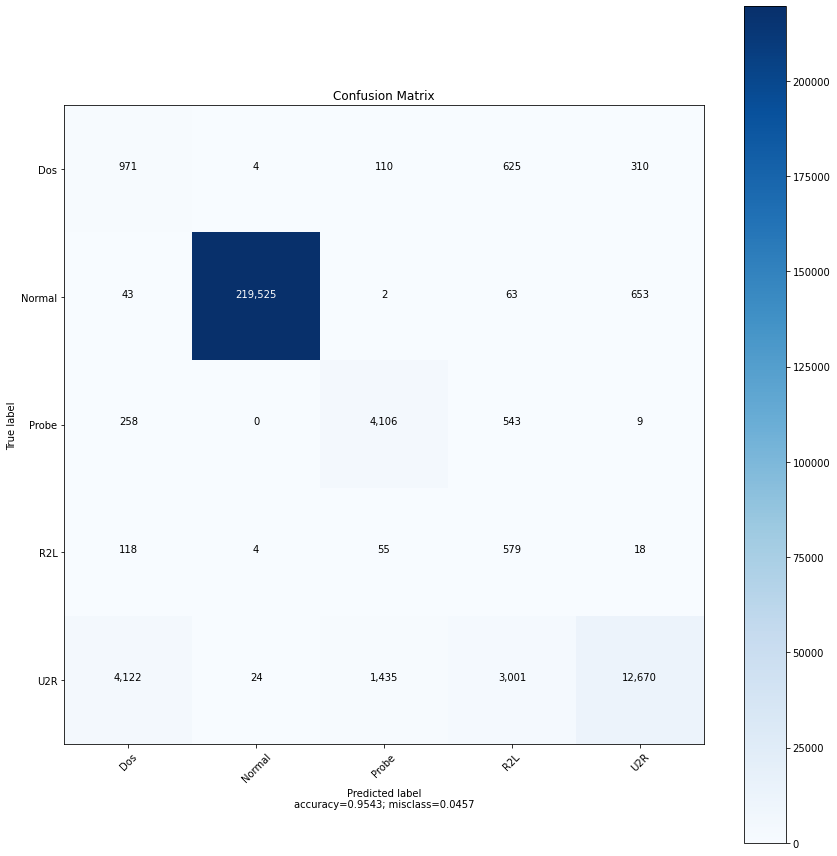

In [ ]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [ ]:
from sklearn.metrics import classification_report
target_names = np.unique(actual)
print(classification_report(actual, test_pred, target_names=target_names, digits=4))

In [ ]:
# emb_num = emb.cpu().detach().numpy()

In [ ]:
# np.save('/content/raw.npy',emb_num)

In [ ]:
# raw_viz = np.load('/content/raw.npy')

In [ ]:
# raw_viz

In [ ]:
# df_umap = pd.DataFrame(raw_viz, columns=['comp1', 'comp2'])

In [ ]:
# df_umap['label'] = le.inverse_transform(y_test)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt 

# plt.figure(figsize=(8,8));
# sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
# plt.legend(loc='upper left', frameon=False)